In [12]:
%matplotlib inline

In [13]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import splitfolders

cudnn.benchmark = True # оптимізація для підвищення продуктивності при використанні GPU з CuDNN (NVIDIA для глибинного навчання)
plt.ion()   # інтерактивний режим (оновлення графіків під час виконання коду)

In [ ]:
data_dir = 'gameplay_data'
splitfolders.ratio('./Dataset', output=data_dir, seed=1337, ratio=(0.8, 0.2, 0)) 

In [15]:
# Аугментація та нормалізація на train
# Нормалізація на val
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # беремо випадкову частину зображення та приводимо її до розміру 224х224
        transforms.RandomHorizontalFlip(), # інвертуємо зображення випадково по горизонталі
        transforms.ToTensor(), # приводимо до torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # нормалізація
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # приводимо зображення до розміру 256х256
        transforms.CenterCrop(224), # беремо частину зображення розміру 224х224 відносно центру
        transforms.ToTensor(), # приводимо до torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Нормалізація
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Розмір тренувальної вибірки: {dataset_sizes['train']}")
print(f"Розмір валідаційної вибріки: {dataset_sizes['val']}")
print(f"Ноутбук виконується на {device}")

Розмір тренувальної вибірки: 8000
Розмір валідаційної вибріки: 2000
Ноутбук виконується на cuda:0


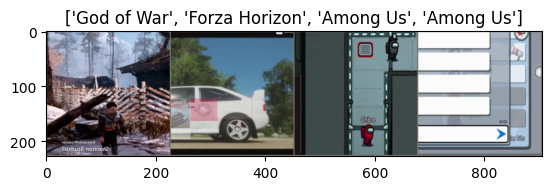

In [16]:
def imshow(inp, title=None):
    """Візуалізація на Tensorflow."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # пауза для оновлення


# беремо батч з train
inputs, classes = next(iter(dataloaders['train']))

# робимо сітку з батча
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # На кожній епосі є фази тренування та фази валідації
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # режим тренування
            else:
                model.eval()   # режим валідації

            running_loss = 0.0
            running_corrects = 0

            # ітерація по батчах
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнулення градієнта
                optimizer.zero_grad()

                # проходження даних через модель
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # зворотнє поширення помилки та оптимізація тільки в режимі тренування
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # підраховую точність по батчах
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # оновлюю lr в режимі навчання
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # зберігання даних для найкращої моделі
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Навчання завершено за {time_elapsed // 60:.0f} хв {time_elapsed % 60:.0f} сек')
    print(f'Найкраща точність на валідаційній вибірці: {best_acc:4f}')

    # завантаження ваг для найкращої моделі
    model.load_state_dict(best_model_wts)
    return model

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
out_ftrs = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, out_ftrs)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Оновлюю ваги для всієї моделі
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Зменшую LR в 0.1 кожну 7-му епоху
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.7932 Acc: 0.7495
val Loss: 0.1222 Acc: 0.9620

Epoch 2/10
----------
train Loss: 0.5135 Acc: 0.8403
val Loss: 0.1012 Acc: 0.9695

Epoch 3/10
----------
train Loss: 0.4134 Acc: 0.8681
val Loss: 0.0987 Acc: 0.9695

Epoch 4/10
----------
train Loss: 0.3709 Acc: 0.8864
val Loss: 0.0829 Acc: 0.9730

Epoch 5/10
----------
train Loss: 0.3365 Acc: 0.9001
val Loss: 0.0765 Acc: 0.9755

Epoch 6/10
----------
train Loss: 0.2858 Acc: 0.9110
val Loss: 0.0644 Acc: 0.9810

Epoch 7/10
----------
train Loss: 0.2726 Acc: 0.9138
val Loss: 0.1212 Acc: 0.9630

Epoch 8/10
----------
train Loss: 0.1832 Acc: 0.9423
val Loss: 0.0447 Acc: 0.9880

Epoch 9/10
----------
train Loss: 0.1640 Acc: 0.9523
val Loss: 0.0333 Acc: 0.9910

Epoch 10/10
----------
train Loss: 0.1567 Acc: 0.9546
val Loss: 0.0402 Acc: 0.9905

Навчання завершено за 10 хв 21 сек
Найкраща точність на валідаційній вибірці: 0.991000


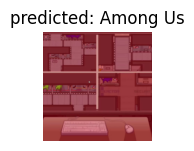

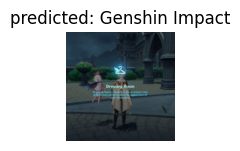

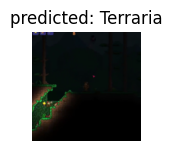

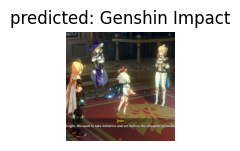

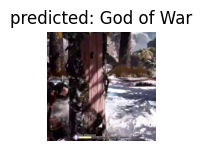

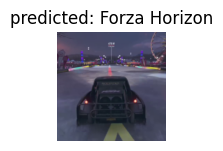

In [24]:
visualize_model(model_ft)

In [26]:
torch.save(model_ft, 'games_classification_model_exp1.pth')